Enviornment Check

In [4]:
import sys
from pathlib import Path
import os 
from datetime import datetime
os.chdir(Path.cwd().parent)
sys.version


'3.8.6 (v3.8.6:db455296be, Sep 23 2020, 13:31:39) \n[Clang 6.0 (clang-600.0.57)]'

# 10000 random seed in train-test split

In [2]:
import numpy as np
from src import DataImport
import matplotlib.pyplot as plt
from src import Models
import shap
import pandas as pd 
import xgboost
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score
from src import Evaluate

df = DataImport.data_reader_by_us(bio=False)

df_seed_selection_lst=pd.DataFrame(columns=['seed','model','imv','roc-auc','pr-auc','f1','efron_r2','ffc_r2','IP'])

#fit the model again to confirm the model performance 
import time
import random
count = 0 
while count <=10000:
    seed = random.randint(1, 100000)
    for model_selection in ['xgb','lgb']:
        print(f'\n{model_selection} and seed is {seed}, count={count}')
        model = Models.Model_fixed_test_size(data=df, test_size=0.3,domain_list=domains['all'], model=model_selection,train_subset_size=1, order=0, y_colname='death',random_state=seed)
        evas = Evaluate.metric(model)
        
        temp = pd.DataFrame({'seed':seed,'model':model_selection,
                             'imv':evas.imv,'roc-auc':evas.auc_score,
                             'pr-auc':evas.pr_auc,'f1':evas.pr_f1,
                             'efron_r2':evas.efron_rsquare,'ffc_r2':evas.ffc_r2,'IP':evas.pr_no_skill},index=[0])
        df_seed_selection_lst.loc[len(df_seed_selection_lst),] = temp.loc[0,]
        if evas.imv>=0.172 and evas.auc_score>=0.817:
            print(f'imv={evas.imv},\nroc-auc={evas.auc_score},\npr-auc={evas.pr_auc},\nf1={evas.pr_f1},\nefron_r2={evas.efron_rsquare},\nffc_r2={evas.ffc_r2},\nIP={evas.pr_no_skill}')
            print("-------------------------------------look at this")
        del model, evas
    
    if count % 100 ==0:
        print(f'now seed is {seed} and we take 100s rest')
        time.sleep(100)
    count+=1

df_seed_selection_lst.to_csv(Path.cwd()/'Data/HRS/seed_selection/10000random_seed_model_performance.csv',index=False)

## Result Check

In [5]:
df_seed_selection_lst=pd.read_csv(Path.cwd()/'Data/HRS/seed_selection/10000random_seed_model_performance.csv')

In [ ]:
[1073,1632,751,702,260,1367,941,571,87,513,1225]
54544 
35543
59790

In [9]:
df_seed_selection_lst.sort_values(by=['imv','f1'],ascending=False)

,seed,model,imv,roc-auc,pr-auc,f1,efron_r2,ffc_r2,IP
5527,53283,lgb,0.200899,0.820010,0.692386,0.581720,0.286678,0.546582,0.285509
9093,17471,lgb,0.192496,0.823164,0.682631,0.591281,0.287089,0.560313,0.288183
5165,45899,lgb,0.191689,0.825030,0.683620,0.586459,0.291774,0.568846,0.289314
8823,5695,lgb,0.190711,0.818371,0.683476,0.563445,0.278389,0.550758,0.287360
3737,46341,lgb,0.190371,0.816236,0.670865,0.584189,0.274108,0.544401,0.286640
...,...,...,...,...,...,...,...,...,...
16438,26782,xgb,0.051812,0.766606,0.584950,0.527027,0.132707,0.492017,0.292605
15944,42459,xgb,0.051509,0.766041,0.586160,0.530045,0.135312,0.499741,0.293634
19478,42459,xgb,0.051509,0.766041,0.586160,0.530045,0.135312,0.499741,0.293634
17634,78977,xgb,0.051192,0.770135,0.575328,0.536036,0.137811,0.514102,0.295793


<Axes: >

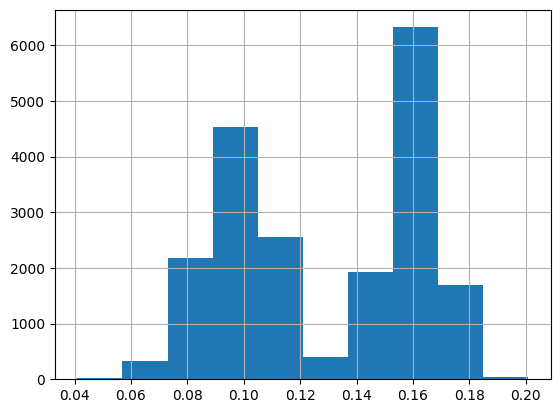

In [8]:
import matplotlib 
df_seed_selection_lst['imv'].hist()

# 1000 Seed in CV


In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import random
import lightgbm as LGB
from src import Evaluate
from src import DataImport
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from pathlib import Path


def store_coef(count, k, model_name, seed, model, domains, df_coef, cv_name):
    NOK = str(count) + '/' + str(k)
    coef_dict = {'model': model_name, 'seed': seed, 'fold_method': cv_name, 'k': k, 'NOK': NOK}
    for coef, feature in zip(model.coef_.T, domains):
        coef_dict[feature] = coef[0]
    temp = pd.DataFrame(coef_dict, index=[0])
    df_coef.loc[len(df_coef),] = temp.loc[0,]
    return df_coef





pd.set_option('precision', 9)
# read data
df = DataImport.data_reader_by_us(bio=True)
domain_dict = DataImport.domain_dict()
domains = list(set(domain_dict['all_bio']))

# control zone

model_name = 'lgb'
test_size = 0.3
seed_min_included = 1
seed_max_not_included = 3
k_list = [1, 10, 50, 100, 200, 500, 1000]

# specify dfs
df_eval = pd.DataFrame(columns=['model', 'seed', 'fold_method', 'k', 'NOK', 'auc', 'f1', 'efron_r2', 'ffc_r2'])
df_coef = pd.DataFrame(columns=['model', 'seed', 'fold_method', 'k', 'NOK'] + domains)

for seed in np.arange(seed_min_included, seed_max_not_included, 1):
    for k in k_list:
        k, seed = int(k), int(seed)
        print('seed is {} and k is {}'.format(seed, k))
        random.seed(seed)
        #  train-test split
        X, test_X, y, test_y = train_test_split(df.drop('death', axis=1), df['death'], test_size=test_size, random_state=seed)
        # X, test_X, y, test_y = train_test_split(df.drop('death', axis=1), df['death'],test_size=0.3)  # , random_state=2021)
        count = 0

        # when k = 1
        if k == 1:
            NOK = str(count) + '/' + str(k)
            if model_name == 'lgb':
                model = LGB.LGBMClassifier(random_state=seed)
                model.fit(X[domains], y)
            else:
                model = LogisticRegression(random_state=seed)
                model.fit(X[domains], y)
                df_coef = store_coef(count + 1, k, model_name, seed, model, domains, df_coef, 'NO fold splitting')


            pred, pred_prob = model.predict(test_X[domains]), model.predict_proba(test_X[domains])[:, 1]
            # TODO: for each split, the predictions should be made on the test set or the cross validation test set?
            Eval = Evaluate.evaluate_metric(test_y, pred, pred_prob, y)
            df_eval.loc[len(df_eval),] = [model, seed, 'NO fold splitting', k, NOK, Eval['auc'], Eval['f1'],
                                          Eval['efron_r2'], Eval['ffc_r2']]
        else:
            cv_dict = {'KFold': KFold(n_splits=k, shuffle=True, random_state=seed),
                       'StratifiedKFold': StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)}
            for cv_name in cv_dict.keys():
                count = 0
                cv = cv_dict[cv_name]

                for train_index, test_index in (cv.split(X, y) if cv_name == 'StratifiedKFold' else cv.split(X)):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                    # fit model with this split
                    if model_name == 'lgb':
                        model = LGB.LGBMClassifier(random_state=seed)
                        model.fit(X_train[domains], y_train)
                        count += 1
                        NOK = str(count) + '/' + str(k)
                    else:
                        model = LogisticRegression(random_state=seed)
                        model.fit(X_train[domains], y_train)
                        count += 1
                        NOK = str(count) + '/' + str(k)

                        df_coef = store_coef(count, k, model_name, seed, model, domains, df_coef, cv_name)

                    # store coefficients


                    # store result evaluations

                    # on the whole validation set
                    '''pred, pred_prob = model.predict(test_X[domains]), model.predict_proba(test_X[domains])[:, 1]
                    # TODO: for each split, the predictions should be made on the whole test set or the cross validation test set?
                    Eval = seed_evaluate_metric(test_y, pred, pred_prob, y_train, test_X['sampWeight'])
                    df_eval.loc[len(df_eval), ] = [model, seed, cv_name, k, NOK, Eval['auc'], Eval['f1'], Eval['efron_r2'], Eval['ffc_r2']]'''

                    # on the  cross validation test set
                    pred, pred_prob = model.predict(test_X[domains]), model.predict_proba(test_X[domains])[:, 1]
                    # TODO: for each split, the predictions should be made on the whole test set or the cross validation test set?
                    Eval = Evaluate.evaluate_metric(test_y, pred, pred_prob, y_train)
                    df_eval.loc[len(df_eval),] = [model, seed, cv_name, k, NOK, Eval['auc'], Eval['f1'],
                                                  Eval['efron_r2'], Eval['ffc_r2']]

# df_eval.to_csv(Path.cwd()/'Seed/df_eval_lgbm_05052022_seed1-2.csv')




## Seed Result Thesis Plot 

In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import random

import matplotlib.pyplot as plt
import lightgbm as LGB
from src import Evaluate
from src import DataImport
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from pathlib import Path

df = DataImport.data_reader_by_us(bio=True)
test_size=0.3
seed = 1
domain_dict = DataImport.domain_dict()
domains = list(set(domain_dict['all_bio_adjusted']))

df_eval=pd.DataFrame(columns=['model','seed','roc_auc','pr_auc','f1','efron_r2','ffc_r2','imv','brier'])

for seed in np.arange(0,1000,1):
    X, test_X, y, test_y = train_test_split(df.drop('death', axis=1), df['death'], test_size=test_size,
                                            random_state=seed)
    model=LGB.LGBMClassifier()
    model.fit(X=X[domains],y=y)

    pred, pred_prob = model.predict(test_X[domains]), model.predict_proba(test_X[domains])[:, 1]

    Eval = Evaluate.evaluate_metric(test_y, pred, pred_prob, y)
    df_eval.loc[len(df_eval),] = [model, seed, Eval['roc_auc'],Eval['auc'], Eval['f1'],
                                  Eval['efron_r2'], Eval['ffc_r2'],Eval['imv'],Eval['brier']]


# df_eval.to_csv(Path.cwd()/'Seed/1fold1000seed.csv')



In [ ]:
df_eval=pd.read_csv(Path.cwd()/'Seed/1fold1000seed.csv',index_col=0)


'''colums=['roc_auc', 'pr_auc', 'f1', 'efron_r2', 'ffc_r2', 'imv']
for column in colums:
    print(column,'&',round(df_eval[column].min(),3),'&',round(df_eval[column].max(),3),'\\\\')
'''


import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig,ax = plt.subplots(3,2)
plt.rcParams["figure.figsize"]=[12,10]
count=0
colums=['roc_auc', 'pr_auc', 'f1', 'efron_r2', 'ffc_r2', 'imv']
column_dict={'roc_auc':'ROC-AUC Score', 'pr_auc':'PR-AUC Score', 'f1':'F1', 'efron_r2':'Efron R2', 'ffc_r2':'FFC R2', 'imv':'IMV'}
fig.subplots_adjust(left=0.09, top=0.98, bottom=0.06, right=0.95)

colors = ['#001c54', '#E89818']
letter_fontsize = 24
label_fontsize = 16
for (m, n), subplot in np.ndenumerate(ax):

    sns.distplot(df_eval[colums[count]],
                 hist_kws={'facecolor': colors[0],'edgecolor': 'k','alpha': 0.6,},
                 kde_kws={'color': colors[1]}, ax=ax[m,n], bins=20)
    # ax[m,n].hist(df_eval[colums[count]],color=color_blue,alpha=0.75,bins=30,edgecolor='black')
    ax[m, n].set_xlabel(column_dict[colums[count]],fontsize=label_fontsize+1)
    ax[m, n].set_ylabel('Density',fontsize=label_fontsize + 1)
    ax[m,n].tick_params(axis='both', which='major', labelsize=label_fontsize)
    count+=1
    ax[m, n].spines['top'].set_visible(False)
    ax[m, n].spines['right'].set_visible(False)
plt.show()


plt.savefig(Path.cwd()/'graphs/seed.pdf')

for column in colums:
    print(column)
    print(df_eval[column].describe())
